In [1]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

print(folium.__version__)

0.2.1


# Load Stations

In [2]:
divvyStations = pd.read_csv('data/Divvy_Trips_2016_Q1Q2/Divvy_Stations_2016_Q1Q2.csv')

In [3]:
divvyStations.head()

,id,name,latitude,longitude,dpcapacity,online_date
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013
3,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,6/21/2013
4,80,Aberdeen St & Monroe St,41.880456,-87.653929,19,6/26/2013


In [4]:
# convert to (n, 2) format for heatmap
stationArr = divvyStations[['latitude', 'longitude']].as_matrix()

# Create Folium map centered around Chicago

In [5]:
m = folium.Map([41.8781, -87.6298], 
               zoom_start=11)
m

In [6]:
for index, row in divvyStations.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=15,
                        popup=row['name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)

In [7]:
# plot heatmap
m.add_children(plugins.HeatMap(stationArr, radius=15))
m

# Analyze activity file to see most used stations for starting and ending trips

In [8]:
# Using generators to read and concatenate multiple dataframes
# Adapted from: http://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

In [9]:
divvyTripFiles = ['data/Divvy_Trips_2016_Q1Q2/Divvy_Trips_2016_Q1.csv', 
                  'data/Divvy_Trips_2016_Q1Q2/Divvy_Trips_2016_04.csv',
                  'data/Divvy_Trips_2016_Q1Q2/Divvy_Trips_2016_05.csv',
                  'data/Divvy_Trips_2016_Q1Q2/Divvy_Trips_2016_06.csv']

divvyTrips = (pd.read_csv(f) for f in divvyTripFiles)
divvyTripsCombined = pd.concat(divvyTrips, ignore_index=True)

In [10]:
divvyTripsCombined.head(2)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,9080551,3/31/2016 23:53,4/1/2016 0:07,155,841,344,Ravenswood Ave & Lawrence Ave,458,Broadway & Thorndale Ave,Subscriber,Male,1986.0
1,9080550,3/31/2016 23:46,3/31/2016 23:57,4831,649,128,Damen Ave & Chicago Ave,213,Leavitt St & North Ave,Subscriber,Male,1980.0


In [11]:
# Curious, how many trips went from Station A all the way to Station A
totalTrips = len(divvyTripsCombined)
sameStationTrips = divvyTripsCombined[divvyTripsCombined.from_station_id == divvyTripsCombined.to_station_id]
sameStationTrips.is_copy = False

In [12]:
print ('Total number of trips: {:,}'.format(totalTrips))
print (('Trips from A -> A: {:,}').format(len(sameStationTrips)))
print (('Trips from A -> A: {:.1%}').format(len(sameStationTrips) / totalTrips))

Total number of trips: 1,469,740
Trips from A -> A: 48,662
Trips from A -> A: 3.3%


In [13]:
# That's a pretty high percentage. Almost 1 in every 5?
# How long are these trips?
# Who is taking them?
# Where are they taking them?
# Tourists who don't know where the next station is? Or subscribes running errards around the neighbourhood?

sameStationTrips['tripInMinutes'] = sameStationTrips['tripduration'] / 60
sameStationTrips.describe()

,trip_id,bikeid,tripduration,from_station_id,to_station_id,birthyear,tripInMinutes
count,4.866200e+04,48662.000000,48662.000000,48662.000000,48662.000000,17682.000000,48662.000000
mean,9.629541e+06,2612.555444,2212.283363,185.950351,185.950351,1979.992987,36.871389
std,4.849162e+05,1511.838186,4368.213498,139.467937,139.467937,11.711183,72.803558
min,8.547271e+06,1.000000,60.000000,2.000000,2.000000,1901.000000,1.000000
25%,9.235808e+06,1318.000000,389.000000,76.000000,76.000000,1973.000000,6.483333
50%,9.686070e+06,2600.000000,1224.000000,162.000000,162.000000,1984.000000,20.400000
75%,1.003303e+07,3884.000000,2579.750000,287.000000,287.000000,1989.000000,42.995833
max,1.042666e+07,5898.000000,85760.000000,618.000000,618.000000,2000.000000,1429.333333


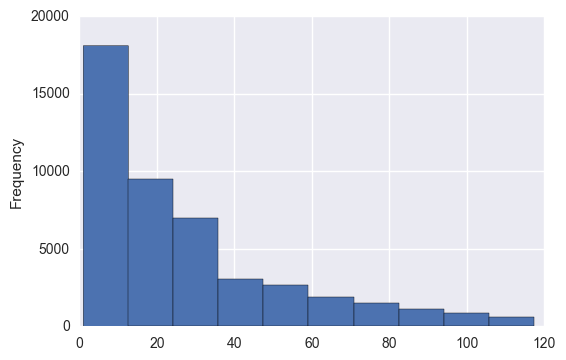

In [14]:
# check out trip in minutes distrubtion
tripDuration = sameStationTrips['tripInMinutes']
tripDuration[tripDuration < tripDuration.quantile(.95)].plot(kind='hist')

usertype
Customer      Axes(0.125,0.125;0.775x0.775)
Subscriber    Axes(0.125,0.125;0.775x0.775)
Name: tripInMinutes, dtype: object

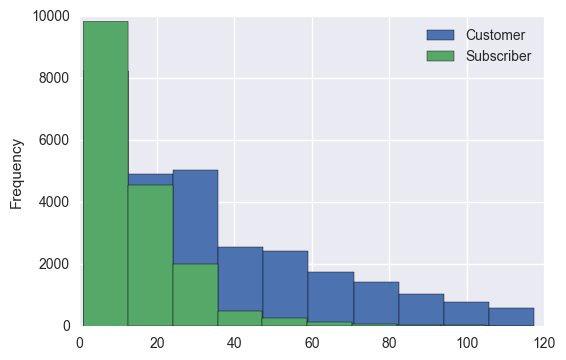

In [15]:
sameStationTrips[tripDuration < 
                 tripDuration.quantile(.95)].groupby('usertype')['tripInMinutes'].plot(kind='hist', 
                                                                                       stacked=True, 
                                                                                       legend=True)

usertype
Customer      Axes(0.125,0.125;0.775x0.775)
Subscriber    Axes(0.125,0.125;0.775x0.775)
Name: tripInMinutes, dtype: object

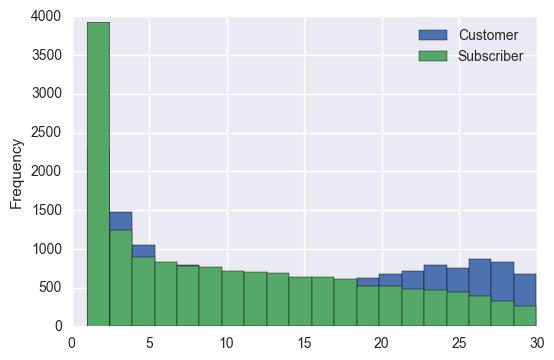

In [16]:
# Divvy's charge more for rides larger than 30 minutes so lets see that distribution
sameStationTrips[sameStationTrips['tripInMinutes'] < 30] \
    .groupby('usertype')['tripInMinutes'] \
    .plot(kind='hist', stacked=True, legend=True, bins=20)

In [17]:
# Acording to Folium docs, we can feed heatmap function with (n, 3) weights
sameStationCountsByStationID = sameStationTrips.groupby('from_station_id')['trip_id'].agg('count')
sameStationCountsByStationID.name = 'numTrips'

In [18]:
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByStationID.to_frame(), how='outer',
                               left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['numTrips'].fillna(value=0)

In [19]:
sameStationCountsDF.head(2)

,id,name,latitude,longitude,dpcapacity,online_date,numTrips
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015,7.0
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015,107.0


# Right now it's difficult to get a map up and running easily

### Let's make a function

In [20]:
def mapPoints(df, latCol='latitude', lonCol='longitude', zoom_start=11,
              plotPoints=False, ptRadius=15, 
              drawHeatmap=False, heatMapWeightsCol=None, heatMapWeightsNormalize=True, heatMapRadius=15):
    
    ## center map in the middle of points center in
    mapMiddleLat = df[latCol].median()
    mapMiddleLon = df[lonCol].median()
    
    m = folium.Map(location=[mapMiddleLat, mapMiddleLon], 
                   zoom_start=zoom_start)
    
    # add points to map
    if plotPoints == True:
        for index, row in df.iterrows():
            folium.CircleMarker([row[latCol], row[lonCol]],
                                radius=ptRadius,
                                popup=row['name'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(m)
    
    # add heatmap
    if drawHeatmap == True:
        # convert to (n, 2) or (n, 3) format
        if heatMapWeightsCol == None:
            colsToPull = [latCol, lonCol]
        else:
            # if we have to normalize
            if heatMapWeightsNormalize == True:
                heatMapWeightColNormalized = heatMapWeightsCol + '_'
                df[heatMapWeightColNormalized] = df[heatMapWeightsCol] / df[heatMapWeightsCol].sum()
                df[heatMapWeightsCol] = df[heatMapWeightColNormalized]
            
            colsToPull = [latCol, lonCol, heatMapWeightsCol]
            
        stationArr = df[colsToPull].as_matrix()
        m.add_children(plugins.HeatMap(stationArr, radius=heatMapRadius))
    
    return m

In [21]:
mapPoints(sameStationCountsDF, plotPoints=True, drawHeatmap=True, heatMapWeightsNormalize=True, 
          heatMapWeightsCol='numTrips')

# See the heatmaps of different types of users (subscribers / customers)

In [22]:
sameStationCountsByUserTypeStationID = sameStationTrips[['from_station_id', 'usertype', 'trip_id']] \
    .groupby(('usertype', 'from_station_id'))\
    .agg('count')

In [23]:
selected = 'Customer'
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByUserTypeStationID.loc[selected],
                               how='outer', left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['trip_id'].fillna(value=0)

mapPoints(sameStationCountsDF, plotPoints=False, drawHeatmap=True, heatMapWeightsNormalize=False, 
          heatMapWeightsCol='numTrips', heatMapRadius=9)

In [24]:
selected = 'Subscriber'
sameStationCountsDF = pd.merge(left=divvyStations, right=sameStationCountsByUserTypeStationID.loc[selected],
                               how='outer', left_on='id', right_index=True)
sameStationCountsDF['numTrips'] = sameStationCountsDF['trip_id'].fillna(value=0)

mapPoints(sameStationCountsDF, plotPoints=False, drawHeatmap=True, heatMapWeightsNormalize=False, 
          heatMapWeightsCol='numTrips', heatMapRadius=9)